In [7]:
# Import libraries and initialize global variables
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
Start_date = utils.date_range()[0]
End_date = utils.date_range()[1]
import datetime 
  
def convert2hours(n): 
    return str(datetime.timedelta(seconds = n)) 

In [8]:
# Pick start date
Start_date

DatePicker(value=datetime.date(2020, 9, 22), description='Start Date')

In [9]:
# Pick end date
End_date

DatePicker(value=datetime.datetime(2021, 3, 9, 23, 24, 18, 920867), description='End Date')

In [10]:
%%time
# database response stored in pandas dataframe
df = utils.db_connect(pem_file='centos.pem',
                      start_date=Start_date.value.strftime("%Y-%m-%d"),
                      end_date=End_date.value.strftime("%Y-%m-%d"))

CPU times: user 17.2 s, sys: 4.95 s, total: 22.1 s
Wall time: 4min 24s


In [11]:
len(df)

431778

In [12]:
# Filter out devices that are not deployed
df['device_deployed'] = np.where(df['mac'].isin(['84CCA89A1706','84CCA899CEE53','CC50E304FA9A',
                   '84CCA899FCA7','84CCA89B799C','CC50E3DA533F','84CCA89A48AF','84CCA899CEE2']), 'Yes', 'No')
# df = df[df.device_deployed=='Yes']
df.tail()

,id,status,userid,timestamp,mac,current,voltage,power,devicestatus,device_deployed
431773,431774,1,505,2021-03-09 23:39:17,CC50E3DA533F,0.54,197,98.8,on,Yes
431774,431775,1,505,2021-03-09 23:39:47,CC50E3DA533F,0.52,204,98.5,on,Yes
431775,431776,1,505,2021-03-09 23:40:16,CC50E3DA533F,0.52,207,98.75,on,Yes
431776,431777,1,505,2021-03-09 23:40:47,CC50E3DA533F,0.52,205,98.56,on,Yes
431777,431778,1,505,2021-03-09 23:41:17,CC50E3DA533F,0.53,202,98.56,on,Yes


In [13]:
# Number of unique mac ids
df.mac.nunique()

100

In [14]:
# Change column types to numeric
df[["current","voltage", "power"]] = df[["current","voltage", "power"]].apply(pd.to_numeric)

In [25]:
# Add date range filter
start_date = '2020-12-05'
end_date = '2020-12-06'
date_mask = (df['timestamp'] > start_date ) & (df['timestamp'] <= end_date)
df_with_mask = df.loc[date_mask]
# Select a specific mac address
df_mac1 = df_with_mask[df_with_mask['mac'].isin(["CC50E3DA533F"])]

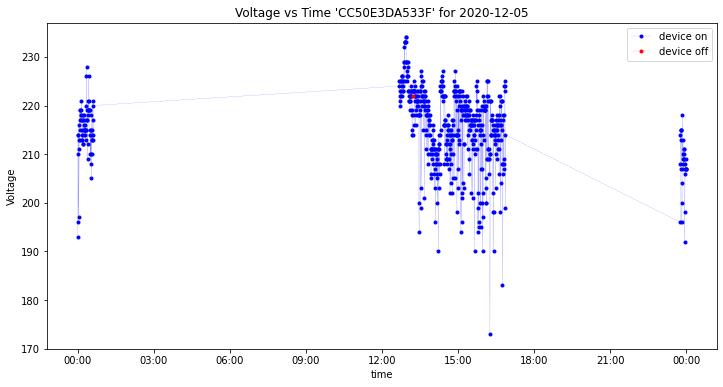

In [26]:
# Plot for Voltage vs Time CC50E3DA533F
fig, ax = plt.subplots(1,1,figsize=(12,6))
on = df_mac1[df_mac1['devicestatus']=='on']
off = df_mac1[df_mac1['devicestatus']=='off']
ax.plot(on["timestamp"], on["voltage"], 'b.-', lw=0.1, label='device on')
ax.plot(off["timestamp"], off["voltage"], 'r.-', lw=0.1,label='device off')

ax.set_title(f'Voltage vs Time \'CC50E3DA533F\' for {start_date}')
ax.set_xlabel('time')
ax.set_ylabel('Voltage')
ax.legend()


myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
ax.xaxis.set_major_formatter(myFmt)
plt.show()

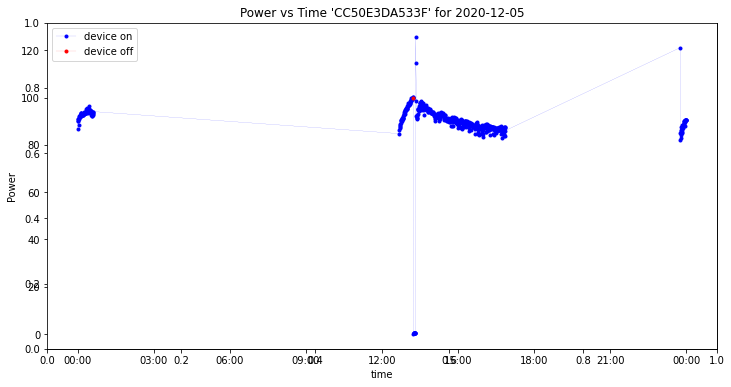

In [30]:
# Plot for Power vs Time CC50E3DA533F
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax = fig.add_subplot(111)
on = df_mac1[df_mac1['devicestatus']=='on']
off = df_mac1[df_mac1['devicestatus']=='off']
ax.plot(on["timestamp"], on["power"], 'b.-', lw=0.1, label='device on')
ax.plot(off["timestamp"], off["power"], 'r.-', lw=0.1,label='device off')
ax.set_title(f'Power vs Time \'CC50E3DA533F\' for {start_date}')
ax.set_xlabel('time')
ax.set_ylabel('Power')
plt.legend()
myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

In [36]:
## groupby mac addresses
df_grouped_mac = df.copy()
df_grouped_mac['date']= df_grouped_mac.timestamp.dt.date
df_grouped_mac['date']= pd.to_datetime(df_grouped_mac['date'])
df_grouped_mac['duration'] = df_grouped_mac.groupby(['mac', 'date'])['timestamp'].diff().dt.total_seconds().fillna(0)
# if it takes more than a minute to record data, the duration is marked as no data received
df_grouped_mac.loc[df_grouped_mac['duration'] >=60, 'devicestatus'] = 'no_data_received' # setting a timeout threshold

## Apply filters
mac_address = ['CC50E3DA533F','CC50E304FA9A'] # select these mac addresses
date = ['2020-09-23'] # select these dates
tmp = df_grouped_mac.groupby(['mac','date','devicestatus'])['duration'].sum().reset_index()
tmp['duration_in_hours'] = tmp['duration'].apply(convert2hours)
tmp[tmp['mac'].isin(mac_address) & tmp['date'].isin(date)]

,mac,date,devicestatus,duration,duration_in_hours
124,CC50E304FA9A,2020-09-23,no_data_received,3604.0,1:00:04
125,CC50E304FA9A,2020-09-23,on,40572.0,11:16:12
217,CC50E3DA533F,2020-09-23,no_data_received,5684.0,1:34:44
218,CC50E3DA533F,2020-09-23,off,238.0,0:03:58
219,CC50E3DA533F,2020-09-23,on,80441.0,22:20:41


## Side Work

In [17]:
df1 = df[df.device_deployed=='Yes']

In [18]:
## groupby mac addresses
df_grouped_mac = df1.copy()
df_grouped_mac['date']= df_grouped_mac.timestamp.dt.date
df_grouped_mac['date']= pd.to_datetime(df_grouped_mac['date'])
x = df_grouped_mac.groupby(['mac', 'date'])
df2 = pd.DataFrame([])
for name,group in x:
    grp_year = group.date.iloc[0].year
    grp_month = group.date.iloc[0].month
    grp_day = group.date.iloc[0].day
    first_row = pd.DataFrame({'id':np.nan, 'status':np.nan, 'userid':np.nan, 
                            'timestamp':pd.Timestamp(grp_year, grp_month, grp_day, 0), 
                            'mac':group.mac.iloc[0], 'current':np.nan, 
                            'voltage':np.nan, 'power':np.nan, 'devicestatus':np.nan,
                            'device_deployed':np.nan, 'date':group.date.iloc[0]
                           }, index =[0]) 
    last_row = pd.DataFrame({'id':np.nan, 'status':np.nan, 'userid':np.nan, 
                        'timestamp':pd.Timestamp(grp_year, grp_month, grp_day, 23,59,59), 
                        'mac':group.mac.iloc[0], 'current':np.nan, 
                        'voltage':np.nan, 'power':np.nan, 'devicestatus':np.nan,
                        'device_deployed':np.nan, 'date':group.date.iloc[0]
                       }, index =[0]) 
    group = pd.concat([first_row, group, last_row]).reset_index(drop = True)
    df2 = pd.concat([df2,group]).reset_index(drop = True)
df2['duration'] = df2.groupby(['mac', 'date'])['timestamp'].diff().dt.total_seconds().fillna(0)
# if it takes more than a minute to record data, the duration is marked as no data received
df2.loc[df2['duration'] >=60, 'devicestatus'] = 'no_data_received' # setting a timeout threshold
df2['duration_in_hours'] = df2['duration'].apply(convert2hours)
df2['duration'] = df2['duration'].div(3600)


In [26]:
list(df2.mac.unique())

['84CCA899CEE2',
 '84CCA899FCA7',
 '84CCA89A1706',
 '84CCA89A48AF',
 '84CCA89B799C',
 'CC50E304FA9A',
 'CC50E3DA533F']

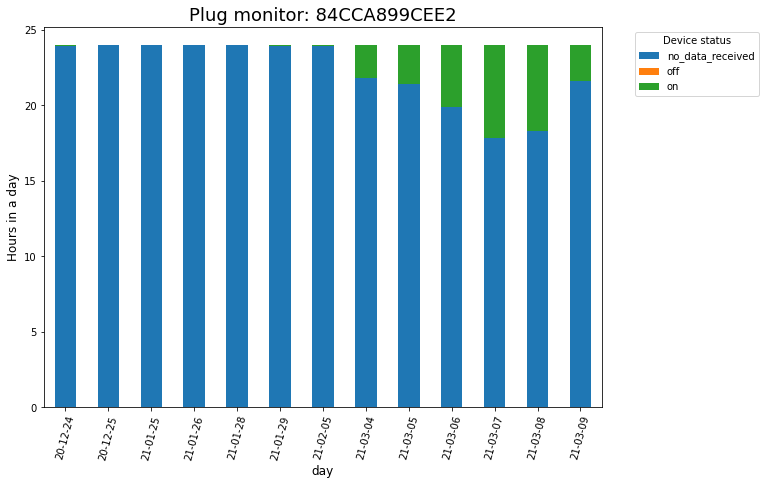

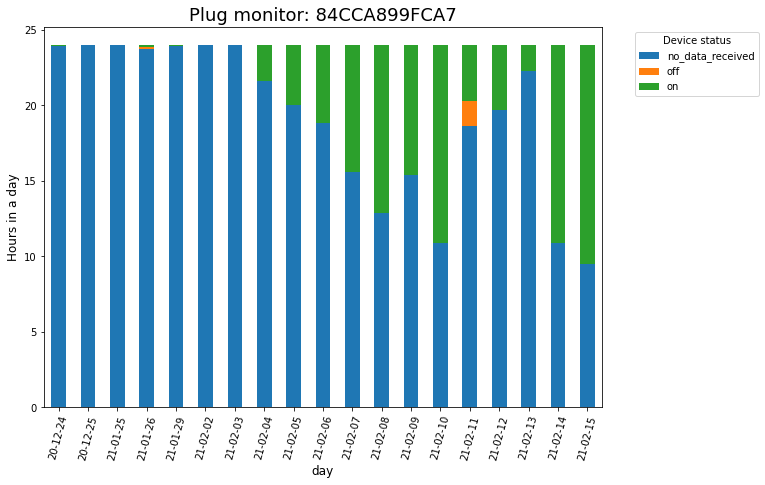

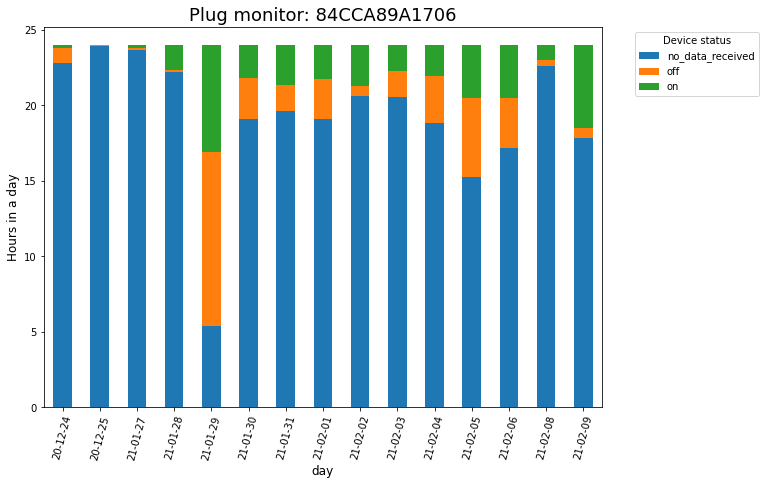

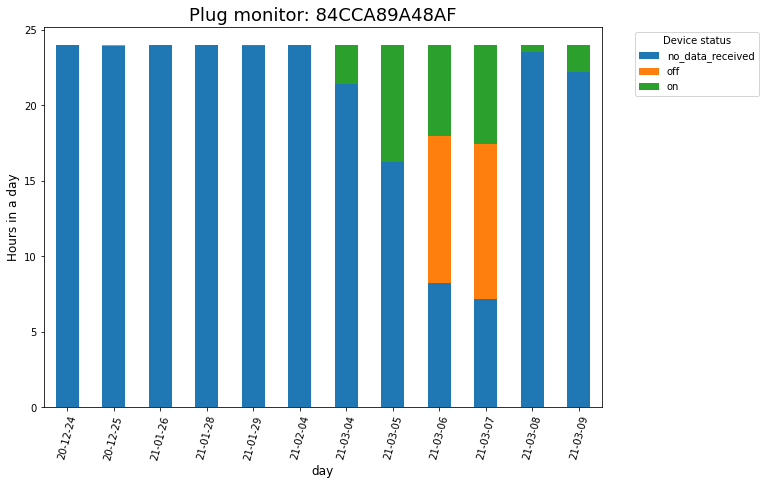

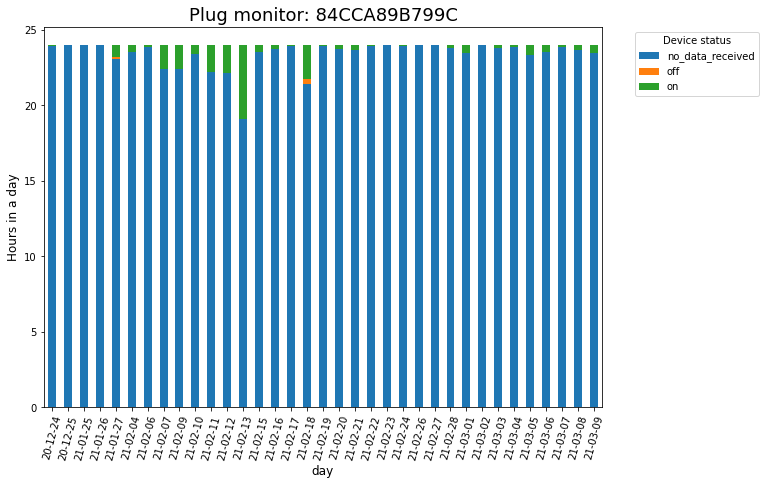

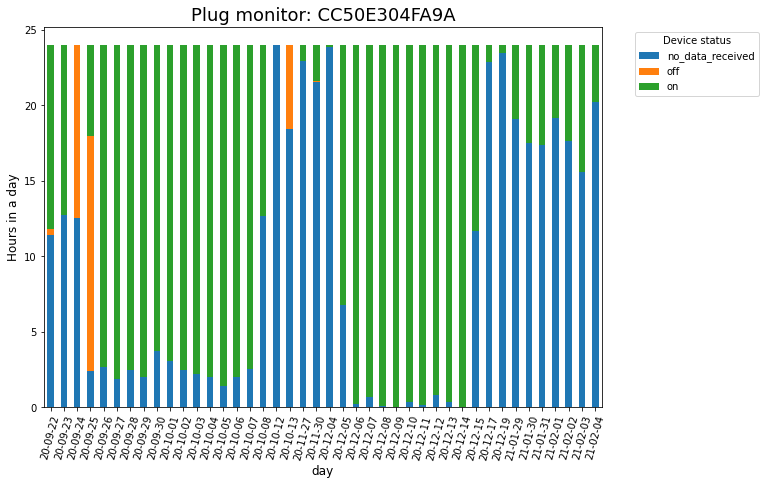

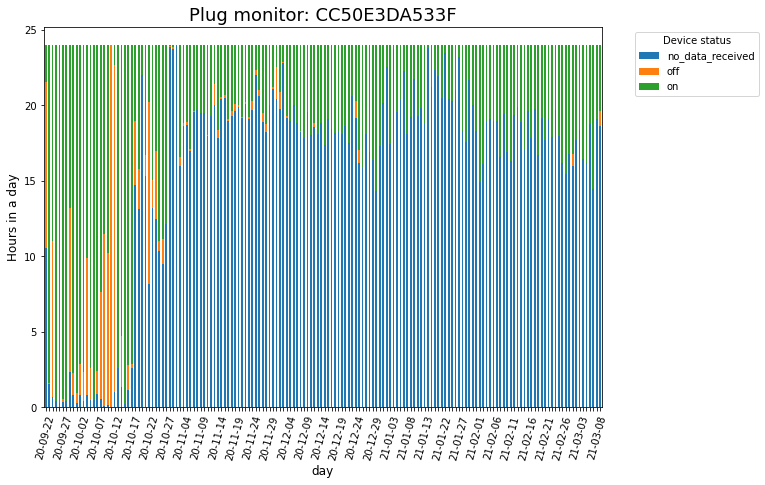

In [48]:
for i in list(df2.mac.unique()):
    p = df2[df2.mac==i]
    q = p.groupby(['mac','date','devicestatus'])['duration'].sum().unstack('devicestatus').fillna(0)
    ax = q.plot(kind='bar', stacked=True, figsize=(10,7))
    ax.set_xlabel('day', fontsize=12)
    ax.set_ylabel('Hours in a day', fontsize=12)
    ax.set_title(f'Plug monitor: {i}', fontsize=18)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([item[17:25] for item in labels])
    if len(labels) > 50:
        every_nth = 5
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
    plt.xticks(rotation=75)
    plt.legend( title='Device status', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [55]:
df3 = df2.groupby(['mac','date'])['voltage'].mean().reset_index()

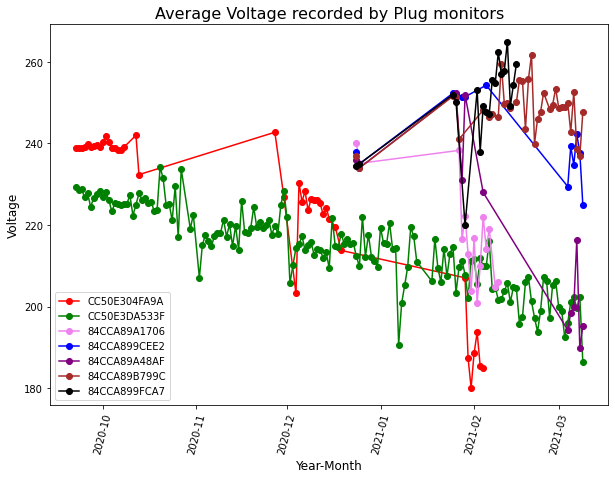

In [84]:
mac_ids = list(df1.mac.unique())
colors = ['red', 'green', 'violet', 'blue', 'purple', 'brown', 'black', 'violet']
fig,ax = plt.subplots(figsize=(10,7))
for n,i in enumerate(mac_ids):
    ax.plot(df3[df3.mac==i].date, df3[df3.mac==i].voltage, color=colors[n], marker='o',label=i)
# ax.plot(df3[df3.mac=='CC50E304FA9A'].date, df3[df3.mac=='CC50E304FA9A'].voltage, color="blue")
ax.set_xlabel('Year-Month', fontsize=12)
ax.set_ylabel('Voltage', fontsize=12)
ax.set_title('Average Voltage recorded by Plug monitors', fontsize=16)
ax.legend()
plt.xticks(rotation=75)
plt.show()